In [1]:
import os
import pandas as pd
import optuna
from qiskit.circuit import QuantumCircuit

import qtpu

from benchmark._plot_util import *

In [4]:
# NUM_QUBITS = 100

SUBCIRCUIT_SIZE = 15
CSV_FILE = "results/cost_standard.csv"

In [3]:
from qtpu.compiler.compiler import trial_to_circuit


def _min_cost_circuit(study: optuna.Study) -> QuantumCircuit:
    best_trial = min(study.best_trials, key=lambda trial: trial.values[0])
    return trial_to_circuit(best_trial)

In [4]:
from qtpu.compiler.compiler import compile_reach_size
from benchmark.ckt import cut_ckt, run_ckt
from benchmark.util import ckt_cost, qtpu_cost, get_info
import time
from qiskit_aer.primitives import Sampler


# def get_result(circuit: QuantumCircuit):
#     start = time.perf_counter()
#     ckt_circ = cut_ckt(circuit, SUBCIRCUIT_SIZE)
#     end = time.perf_counter()
#     print(f"ckt: {end-start}")

#     start = time.perf_counter()
#     qtpu_circuit = compile_reach_size(circuit, SUBCIRCUIT_SIZE, show_progress_bar=True)
#     end = time.perf_counter()
#     print(f"qtpu: {end-start}")

#     return {"ckt_cost": ckt_cost(ckt_circ), "qtpu_cost": qtpu_cost(qtpu_circuit)}

In [5]:
from benchmark.ansatz import generate_ansatz


BENCHMARKS = [
    {"name": name, "num_qubits": q, "reps": 2}
    for name in ["zz", "linear"]
    for q in range(20, 101, 10)
]

In [6]:
from benchmark.util import append_to_csv
from qtpu.compiler.compiler import find_least_cost_trial

# optuna.logging.set_verbosity(optuna.logging.INFO)

for bench in BENCHMARKS:
    circuit = generate_ansatz(**bench)

    start = time.perf_counter()
    qtpu_circuit = compile_reach_size(
        circuit,
        SUBCIRCUIT_SIZE,
        show_progress_bar=True,
        pareto_fn=find_least_cost_trial,
    )
    end = time.perf_counter()

    info = get_info(qtpu_circuit)

    append_to_csv(CSV_FILE, {**bench, **info})

  0%|          | 0/100 [00:00<?, ?it/s]

[FrozenTrial(number=14, state=1, values=[1179920.0, 0.9869847850236957], datetime_start=datetime.datetime(2024, 8, 12, 13, 37, 5, 935724), datetime_complete=datetime.datetime(2024, 8, 12, 13, 37, 5, 982599), params={'compress': 'none', 'choose_leaf': 'qubits', 'random_strength': 6.940542181422164, 'weight_edges': 'const', 'imbalance': 0.8107360333634734, 'imbalance_decay': -4.696964934006031, 'parts': 6, 'parts_decay': 0.49031921129526157, 'mode': 'direct', 'objective': 'km1', 'fix_output_nodes': ''}, user_attrs={'ir': <qtpu.compiler.compress.CompressedIR object at 0x7f220973c6d0>, 'tree': <ContractionTree(N=270, branches=5, complete=False)>}, system_attrs={'nsga2:generation': 0}, intermediate_values={}, distributions={'compress': CategoricalDistribution(choices=('qubits', '2q', 'none')), 'choose_leaf': CategoricalDistribution(choices=('qubits',)), 'random_strength': FloatDistribution(high=10.0, log=False, low=0.01, step=None), 'weight_edges': CategoricalDistribution(choices=('const', 

  0%|          | 0/100 [00:00<?, ?it/s]

[FrozenTrial(number=5, state=1, values=[6561.0, 0.9796097214374484], datetime_start=datetime.datetime(2024, 8, 12, 13, 37, 17, 738458), datetime_complete=datetime.datetime(2024, 8, 12, 13, 37, 17, 747124), params={'compress': 'qubits', 'choose_leaf': 'qubits', 'random_strength': 3.235051329775763, 'weight_edges': 'const', 'imbalance': 0.3458233170410059, 'imbalance_decay': -1.2734930860240756, 'parts': 4, 'parts_decay': 0.9685875951176555, 'mode': 'recursive', 'objective': 'cut', 'fix_output_nodes': 'auto'}, user_attrs={'ir': <qtpu.compiler.compress.CompressedIR object at 0x7f20d89555d0>, 'tree': <ContractionTree(N=30, branches=1, complete=False)>}, system_attrs={'nsga2:generation': 0}, intermediate_values={}, distributions={'compress': CategoricalDistribution(choices=('qubits', '2q', 'none')), 'choose_leaf': CategoricalDistribution(choices=('qubits',)), 'random_strength': FloatDistribution(high=10.0, log=False, low=0.01, step=None), 'weight_edges': CategoricalDistribution(choices=('co

  0%|          | 0/100 [00:00<?, ?it/s]

[FrozenTrial(number=7, state=1, values=[35979536.0, 0.9867873979365388], datetime_start=datetime.datetime(2024, 8, 12, 13, 37, 43, 254269), datetime_complete=datetime.datetime(2024, 8, 12, 13, 37, 43, 375638), params={'compress': 'none', 'choose_leaf': 'qubits', 'random_strength': 0.5740247361910791, 'weight_edges': 'const', 'imbalance': 0.4468261859378475, 'imbalance_decay': 2.553658637691205, 'parts': 12, 'parts_decay': 0.5864028957310479, 'mode': 'direct', 'objective': 'km1', 'fix_output_nodes': ''}, user_attrs={'ir': <qtpu.compiler.compress.CompressedIR object at 0x7f20599b73d0>, 'tree': <ContractionTree(N=550, branches=11, complete=False)>}, system_attrs={'nsga2:generation': 0}, intermediate_values={}, distributions={'compress': CategoricalDistribution(choices=('qubits', '2q', 'none')), 'choose_leaf': CategoricalDistribution(choices=('qubits',)), 'random_strength': FloatDistribution(high=10.0, log=False, low=0.01, step=None), 'weight_edges': CategoricalDistribution(choices=('const

  0%|          | 0/100 [00:00<?, ?it/s]

/home/di75piq/qtpu/.venv/lib/python3.11/site-packages/cotengra/hyperoptimizers/hyper.py:307: UserWarning: Trial error: Optimization timed out. Set `HyperOptimizer` kwarg `on_trial_error='raise'` to raise this error, or `on_trial_error='ignore'` to silence.
  warnings.warn(


[FrozenTrial(number=9, state=1, values=[5040144.0, 0.9810803122177046], datetime_start=datetime.datetime(2024, 8, 12, 13, 38, 20, 740), datetime_complete=datetime.datetime(2024, 8, 12, 13, 38, 20, 109331), params={'compress': 'none', 'choose_leaf': 'qubits', 'random_strength': 0.4688128081440513, 'weight_edges': 'log', 'imbalance': 0.8275775681104669, 'imbalance_decay': 3.7951430435607563, 'parts': 13, 'parts_decay': 0.5171661171603248, 'mode': 'recursive', 'objective': 'km1', 'fix_output_nodes': 'auto'}, user_attrs={'ir': <qtpu.compiler.compress.CompressedIR object at 0x7f205925c910>, 'tree': <ContractionTree(N=690, branches=4, complete=False)>}, system_attrs={'nsga2:generation': 0}, intermediate_values={}, distributions={'compress': CategoricalDistribution(choices=('qubits', '2q', 'none')), 'choose_leaf': CategoricalDistribution(choices=('qubits',)), 'random_strength': FloatDistribution(high=10.0, log=False, low=0.01, step=None), 'weight_edges': CategoricalDistribution(choices=('cons

  0%|          | 0/100 [00:00<?, ?it/s]

[FrozenTrial(number=25, state=1, values=[559613934.0, 0.9944153723166914], datetime_start=datetime.datetime(2024, 8, 12, 13, 39, 36, 975395), datetime_complete=datetime.datetime(2024, 8, 12, 13, 39, 37, 11649), params={'compress': 'qubits', 'choose_leaf': 'qubits', 'random_strength': 8.610560381636972, 'weight_edges': 'const', 'imbalance': 0.7734826000798157, 'imbalance_decay': -3.5151517863190342, 'parts': 15, 'parts_decay': 0.183153382685472, 'mode': 'recursive', 'objective': 'cut', 'fix_output_nodes': ''}, user_attrs={'ir': <qtpu.compiler.compress.CompressedIR object at 0x7f20532e8050>, 'tree': <ContractionTree(N=60, branches=14, complete=False)>}, system_attrs={'nsga2:generation': 0}, intermediate_values={}, distributions={'compress': CategoricalDistribution(choices=('qubits', '2q', 'none')), 'choose_leaf': CategoricalDistribution(choices=('qubits',)), 'random_strength': FloatDistribution(high=10.0, log=False, low=0.01, step=None), 'weight_edges': CategoricalDistribution(choices=('

  0%|          | 0/100 [00:00<?, ?it/s]

[FrozenTrial(number=19, state=1, values=[344380329.0, 0.990247378264551], datetime_start=datetime.datetime(2024, 8, 12, 13, 40, 46, 180541), datetime_complete=datetime.datetime(2024, 8, 12, 13, 40, 46, 215175), params={'compress': 'qubits', 'choose_leaf': 'qubits', 'random_strength': 5.314827559713974, 'weight_edges': 'const', 'imbalance': 0.9454356752603394, 'imbalance_decay': 4.618137265423705, 'parts': 10, 'parts_decay': 0.7122115055349119, 'mode': 'direct', 'objective': 'cut', 'fix_output_nodes': ''}, user_attrs={'ir': <qtpu.compiler.compress.CompressedIR object at 0x7f204a1c1610>, 'tree': <ContractionTree(N=70, branches=9, complete=False)>}, system_attrs={'nsga2:generation': 0}, intermediate_values={}, distributions={'compress': CategoricalDistribution(choices=('qubits', '2q', 'none')), 'choose_leaf': CategoricalDistribution(choices=('qubits',)), 'random_strength': FloatDistribution(high=10.0, log=False, low=0.01, step=None), 'weight_edges': CategoricalDistribution(choices=('const

  0%|          | 0/100 [00:00<?, ?it/s]

/home/di75piq/qtpu/.venv/lib/python3.11/site-packages/cotengra/hyperoptimizers/hyper.py:307: UserWarning: Trial error: Optimization timed out. Set `HyperOptimizer` kwarg `on_trial_error='raise'` to raise this error, or `on_trial_error='ignore'` to silence.
  warnings.warn(
/home/di75piq/qtpu/.venv/lib/python3.11/site-packages/cotengra/hyperoptimizers/hyper.py:307: UserWarning: Trial error: Optimization timed out. Set `HyperOptimizer` kwarg `on_trial_error='raise'` to raise this error, or `on_trial_error='ignore'` to silence.
  warnings.warn(


[FrozenTrial(number=19, state=1, values=[602660655.0, 0.9930240953515693], datetime_start=datetime.datetime(2024, 8, 12, 13, 41, 56, 939543), datetime_complete=datetime.datetime(2024, 8, 12, 13, 42, 0, 525244), params={'compress': 'qubits', 'choose_leaf': 'qubits', 'random_strength': 3.7272390552744836, 'weight_edges': 'const', 'imbalance': 0.016131114742506673, 'imbalance_decay': 3.0666208003054347, 'parts': 16, 'parts_decay': 0.36600204105382894, 'mode': 'direct', 'objective': 'cut', 'fix_output_nodes': ''}, user_attrs={'ir': <qtpu.compiler.compress.CompressedIR object at 0x7f2058573e90>, 'tree': <ContractionTree(N=80, branches=15, complete=False)>}, system_attrs={'nsga2:generation': 0}, intermediate_values={}, distributions={'compress': CategoricalDistribution(choices=('qubits', '2q', 'none')), 'choose_leaf': CategoricalDistribution(choices=('qubits',)), 'random_strength': FloatDistribution(high=10.0, log=False, low=0.01, step=None), 'weight_edges': CategoricalDistribution(choices=(

/home/di75piq/qtpu/benchmark/util.py:43: RuntimeWarning: overflow encountered in scalar multiply
  "ckt_cost": np.prod([len(qpd.coeffs) for qpd in qpds])


  0%|          | 0/100 [00:00<?, ?it/s]

[FrozenTrial(number=17, state=1, values=[468741268240.0, 0.995808598531185], datetime_start=datetime.datetime(2024, 8, 12, 13, 43, 0, 368674), datetime_complete=datetime.datetime(2024, 8, 12, 13, 43, 0, 891262), params={'compress': 'none', 'choose_leaf': 'qubits', 'random_strength': 5.590466399438273, 'weight_edges': 'const', 'imbalance': 0.394803059621206, 'imbalance_decay': 3.7317398517532325, 'parts': 15, 'parts_decay': 0.08625473020674479, 'mode': 'direct', 'objective': 'km1', 'fix_output_nodes': ''}, user_attrs={'ir': <qtpu.compiler.compress.CompressedIR object at 0x7f2052c423d0>, 'tree': <ContractionTree(N=1250, branches=50, complete=False)>}, system_attrs={'nsga2:generation': 0}, intermediate_values={}, distributions={'compress': CategoricalDistribution(choices=('qubits', '2q', 'none')), 'choose_leaf': CategoricalDistribution(choices=('qubits',)), 'random_strength': FloatDistribution(high=10.0, log=False, low=0.01, step=None), 'weight_edges': CategoricalDistribution(choices=('co

/home/di75piq/qtpu/benchmark/util.py:43: RuntimeWarning: overflow encountered in scalar multiply
  "ckt_cost": np.prod([len(qpd.coeffs) for qpd in qpds])


  0%|          | 0/100 [00:00<?, ?it/s]

[FrozenTrial(number=12, state=1, values=[1255679632144.0, 0.9965059434602331], datetime_start=datetime.datetime(2024, 8, 12, 13, 44, 11, 639839), datetime_complete=datetime.datetime(2024, 8, 12, 13, 44, 12, 377289), params={'compress': 'none', 'choose_leaf': 'qubits', 'random_strength': 1.1466525074242304, 'weight_edges': 'const', 'imbalance': 0.21705950538971008, 'imbalance_decay': 1.8664184850687215, 'parts': 16, 'parts_decay': 0.30502543636478086, 'mode': 'direct', 'objective': 'km1', 'fix_output_nodes': ''}, user_attrs={'ir': <qtpu.compiler.compress.CompressedIR object at 0x7f2049002bd0>, 'tree': <ContractionTree(N=1390, branches=51, complete=False)>}, system_attrs={'nsga2:generation': 0}, intermediate_values={}, distributions={'compress': CategoricalDistribution(choices=('qubits', '2q', 'none')), 'choose_leaf': CategoricalDistribution(choices=('qubits',)), 'random_strength': FloatDistribution(high=10.0, log=False, low=0.01, step=None), 'weight_edges': CategoricalDistribution(choic

  0%|          | 0/100 [00:00<?, ?it/s]

[FrozenTrial(number=0, state=1, values=[81.0, 0.990247378264551], datetime_start=datetime.datetime(2024, 8, 12, 13, 45, 9, 981235), datetime_complete=datetime.datetime(2024, 8, 12, 13, 45, 9, 988155), params={'compress': 'qubits', 'choose_leaf': 'qubits', 'random_strength': 6.5769056644184944, 'weight_edges': 'const', 'imbalance': 0.3019948273462377, 'imbalance_decay': -2.1610932437614028, 'parts': 4, 'parts_decay': 0.5980792251837294, 'mode': 'recursive', 'objective': 'km1', 'fix_output_nodes': 'auto'}, user_attrs={'ir': <qtpu.compiler.compress.CompressedIR object at 0x7f2209d25490>, 'tree': <ContractionTree(N=20, branches=1, complete=False)>}, system_attrs={'nsga2:generation': 0}, intermediate_values={}, distributions={'compress': CategoricalDistribution(choices=('qubits', '2q', 'none')), 'choose_leaf': CategoricalDistribution(choices=('qubits',)), 'random_strength': FloatDistribution(high=10.0, log=False, low=0.01, step=None), 'weight_edges': CategoricalDistribution(choices=('const'

  0%|          | 0/100 [00:00<?, ?it/s]

[FrozenTrial(number=2, state=1, values=[6642.0, 0.9900493386913719], datetime_start=datetime.datetime(2024, 8, 12, 13, 45, 20, 732256), datetime_complete=datetime.datetime(2024, 8, 12, 13, 45, 20, 739834), params={'compress': 'qubits', 'choose_leaf': 'qubits', 'random_strength': 8.66022004401928, 'weight_edges': 'const', 'imbalance': 0.38673812096430327, 'imbalance_decay': -4.5344448334927465, 'parts': 3, 'parts_decay': 0.2001608913478352, 'mode': 'direct', 'objective': 'km1', 'fix_output_nodes': ''}, user_attrs={'ir': <qtpu.compiler.compress.CompressedIR object at 0x7f20591f8590>, 'tree': <ContractionTree(N=30, branches=2, complete=False)>}, system_attrs={'nsga2:generation': 0}, intermediate_values={}, distributions={'compress': CategoricalDistribution(choices=('qubits', '2q', 'none')), 'choose_leaf': CategoricalDistribution(choices=('qubits',)), 'random_strength': FloatDistribution(high=10.0, log=False, low=0.01, step=None), 'weight_edges': CategoricalDistribution(choices=('const', '

  0%|          | 0/100 [00:00<?, ?it/s]

[FrozenTrial(number=3, state=1, values=[13203.0, 0.9900493386913719], datetime_start=datetime.datetime(2024, 8, 12, 13, 45, 44, 193577), datetime_complete=datetime.datetime(2024, 8, 12, 13, 45, 44, 206061), params={'compress': 'qubits', 'choose_leaf': 'qubits', 'random_strength': 0.020973136521808572, 'weight_edges': 'const', 'imbalance': 0.9422607049344796, 'imbalance_decay': -0.1817259720511979, 'parts': 8, 'parts_decay': 0.5736257367002443, 'mode': 'recursive', 'objective': 'cut', 'fix_output_nodes': 'auto'}, user_attrs={'ir': <qtpu.compiler.compress.CompressedIR object at 0x7f204af55e90>, 'tree': <ContractionTree(N=40, branches=3, complete=False)>}, system_attrs={'nsga2:generation': 0}, intermediate_values={}, distributions={'compress': CategoricalDistribution(choices=('qubits', '2q', 'none')), 'choose_leaf': CategoricalDistribution(choices=('qubits',)), 'random_strength': FloatDistribution(high=10.0, log=False, low=0.01, step=None), 'weight_edges': CategoricalDistribution(choices=

  0%|          | 0/100 [00:00<?, ?it/s]

[FrozenTrial(number=4, state=1, values=[46008.0, 0.9940176658287095], datetime_start=datetime.datetime(2024, 8, 12, 13, 46, 12, 442671), datetime_complete=datetime.datetime(2024, 8, 12, 13, 46, 12, 458878), params={'compress': 'qubits', 'choose_leaf': 'qubits', 'random_strength': 5.982194073046817, 'weight_edges': 'const', 'imbalance': 0.10199192588264064, 'imbalance_decay': -3.1421908517563066, 'parts': 9, 'parts_decay': 0.31759610586690223, 'mode': 'recursive', 'objective': 'cut', 'fix_output_nodes': ''}, user_attrs={'ir': <qtpu.compiler.compress.CompressedIR object at 0x7f20515d02d0>, 'tree': <ContractionTree(N=50, branches=8, complete=False)>}, system_attrs={'nsga2:generation': 0}, intermediate_values={}, distributions={'compress': CategoricalDistribution(choices=('qubits', '2q', 'none')), 'choose_leaf': CategoricalDistribution(choices=('qubits',)), 'random_strength': FloatDistribution(high=10.0, log=False, low=0.01, step=None), 'weight_edges': CategoricalDistribution(choices=('con

  0%|          | 0/100 [00:00<?, ?it/s]

[FrozenTrial(number=1, state=1, values=[85374.0, 0.9960077901291329], datetime_start=datetime.datetime(2024, 8, 12, 13, 46, 59, 790606), datetime_complete=datetime.datetime(2024, 8, 12, 13, 46, 59, 814658), params={'compress': 'qubits', 'choose_leaf': 'qubits', 'random_strength': 8.872984584807842, 'weight_edges': 'const', 'imbalance': 0.24379538953859142, 'imbalance_decay': 4.53890991601738, 'parts': 15, 'parts_decay': 0.10296733655827595, 'mode': 'recursive', 'objective': 'km1', 'fix_output_nodes': ''}, user_attrs={'ir': <qtpu.compiler.compress.CompressedIR object at 0x7f2053bd2490>, 'tree': <ContractionTree(N=60, branches=14, complete=False)>}, system_attrs={'nsga2:generation': 0}, intermediate_values={}, distributions={'compress': CategoricalDistribution(choices=('qubits', '2q', 'none')), 'choose_leaf': CategoricalDistribution(choices=('qubits',)), 'random_strength': FloatDistribution(high=10.0, log=False, low=0.01, step=None), 'weight_edges': CategoricalDistribution(choices=('cons

  0%|          | 0/100 [00:00<?, ?it/s]

[FrozenTrial(number=1, state=1, values=[52569.0, 0.9930240953515693], datetime_start=datetime.datetime(2024, 8, 12, 13, 47, 58, 190752), datetime_complete=datetime.datetime(2024, 8, 12, 13, 47, 58, 213853), params={'compress': 'qubits', 'choose_leaf': 'qubits', 'random_strength': 5.95544528017923, 'weight_edges': 'const', 'imbalance': 0.39959120463671033, 'imbalance_decay': 2.1676481248149226, 'parts': 10, 'parts_decay': 0.6778398194949811, 'mode': 'recursive', 'objective': 'km1', 'fix_output_nodes': ''}, user_attrs={'ir': <qtpu.compiler.compress.CompressedIR object at 0x7f20504a0a10>, 'tree': <ContractionTree(N=70, branches=9, complete=False)>}, system_attrs={'nsga2:generation': 0}, intermediate_values={}, distributions={'compress': CategoricalDistribution(choices=('qubits', '2q', 'none')), 'choose_leaf': CategoricalDistribution(choices=('qubits',)), 'random_strength': FloatDistribution(high=10.0, log=False, low=0.01, step=None), 'weight_edges': CategoricalDistribution(choices=('const

  0%|          | 0/100 [00:00<?, ?it/s]

[FrozenTrial(number=2, state=1, values=[91935.0, 0.9950122304230093], datetime_start=datetime.datetime(2024, 8, 12, 13, 49, 15, 370744), datetime_complete=datetime.datetime(2024, 8, 12, 13, 49, 15, 401923), params={'compress': 'qubits', 'choose_leaf': 'qubits', 'random_strength': 6.059905444492161, 'weight_edges': 'const', 'imbalance': 0.14985650265515835, 'imbalance_decay': -0.7574305985970362, 'parts': 16, 'parts_decay': 0.9896181315306262, 'mode': 'direct', 'objective': 'km1', 'fix_output_nodes': ''}, user_attrs={'ir': <qtpu.compiler.compress.CompressedIR object at 0x7f2058a24350>, 'tree': <ContractionTree(N=80, branches=15, complete=False)>}, system_attrs={'nsga2:generation': 0}, intermediate_values={}, distributions={'compress': CategoricalDistribution(choices=('qubits', '2q', 'none')), 'choose_leaf': CategoricalDistribution(choices=('qubits',)), 'random_strength': FloatDistribution(high=10.0, log=False, low=0.01, step=None), 'weight_edges': CategoricalDistribution(choices=('const

  0%|          | 0/100 [00:00<?, ?it/s]

[FrozenTrial(number=9, state=1, values=[65691.0, 0.9920315179979188], datetime_start=datetime.datetime(2024, 8, 12, 13, 50, 28, 614417), datetime_complete=datetime.datetime(2024, 8, 12, 13, 50, 28, 644546), params={'compress': 'qubits', 'choose_leaf': 'qubits', 'random_strength': 5.866315994459443, 'weight_edges': 'const', 'imbalance': 0.9797974507754688, 'imbalance_decay': 3.5245417534460177, 'parts': 12, 'parts_decay': 0.020842165834345505, 'mode': 'direct', 'objective': 'cut', 'fix_output_nodes': ''}, user_attrs={'ir': <qtpu.compiler.compress.CompressedIR object at 0x7f20533df190>, 'tree': <ContractionTree(N=90, branches=11, complete=False)>}, system_attrs={'nsga2:generation': 0}, intermediate_values={}, distributions={'compress': CategoricalDistribution(choices=('qubits', '2q', 'none')), 'choose_leaf': CategoricalDistribution(choices=('qubits',)), 'random_strength': FloatDistribution(high=10.0, log=False, low=0.01, step=None), 'weight_edges': CategoricalDistribution(choices=('const

  0%|          | 0/100 [00:00<?, ?it/s]

[FrozenTrial(number=1, state=1, values=[39447.0, 0.9870834933730329], datetime_start=datetime.datetime(2024, 8, 12, 13, 51, 26, 878983), datetime_complete=datetime.datetime(2024, 8, 12, 13, 51, 26, 908154), params={'compress': 'qubits', 'choose_leaf': 'qubits', 'random_strength': 2.1932761570871193, 'weight_edges': 'const', 'imbalance': 0.47388868665574796, 'imbalance_decay': 1.5032099176225895, 'parts': 8, 'parts_decay': 0.5616065531193528, 'mode': 'recursive', 'objective': 'cut', 'fix_output_nodes': ''}, user_attrs={'ir': <qtpu.compiler.compress.CompressedIR object at 0x7f204a259990>, 'tree': <ContractionTree(N=100, branches=7, complete=False)>}, system_attrs={'nsga2:generation': 0}, intermediate_values={}, distributions={'compress': CategoricalDistribution(choices=('qubits', '2q', 'none')), 'choose_leaf': CategoricalDistribution(choices=('qubits',)), 'random_strength': FloatDistribution(high=10.0, log=False, low=0.01, step=None), 'weight_edges': CategoricalDistribution(choices=('con

In [7]:
from benchmark._plot_util import *


def plot(benches: list[str], ax: plt.Axes):
    df = pd.read_csv(CSV_FILE)
    print(df)
    df = df[df["reps"] == 3]
    df = df[df["name"].isin(benches)]
    df = df[["name", "num_qubits", "reps", "qtpu_cost", "ckt_cost"]]
    # print(df)
    # rename columns
    df = df.rename(columns={"ckt_cost": "CKT", "qtpu_cost": "QTPU"})

    df.sort_index()
    df_mean = df.groupby(["name", "num_qubits", "reps"]).mean()
    # df_std = df.groupby(["name", "num_qubits"]).std().reset_index().drop("name", axis=1)

    df_mean.plot.bar(
        rot=22,
        width=0.8,
        edgecolor="black",
        linewidth=2,
        ax=ax,
        legend=False,
        # yerr=df_std.to_numpy().T,
    )

    hatches = ["**", "//"]

    color_to_hatch = {}

    i = 0
    for patch in ax.patches:
        if patch.get_facecolor() not in color_to_hatch:
            color_to_hatch[patch.get_facecolor()] = hatches[i % len(hatches)]
            i += 1

    for patch in ax.patches:
        patch.set_hatch(color_to_hatch[patch.get_facecolor()])

    ax.set_yscale("log")
    # ax.set_yticklabels([f"$10^{{{int(x.get_text())}}}$" for x in ax.get_yticklabels()])
    ax.set_title("Lower is better ↓", fontweight="bold", color="midnightblue")
    ax.set_xlabel("")
    ax.set_ylabel("Contraction Cost [FLOPs]")

      name  num_qubits  reps  qtpu_cost             ckt_cost  num_qpds  \
0   linear          20     2         78                  108         2   
1   linear          30     2         78                  108         2   
2   linear          40     2       2814               419904         6   
3   linear          50     2       2814               419904         6   
4   linear          60     2       2814               419904         6   
5   linear          70     2       5550            906992640        10   
6       zz          20     2        762                 1152         3   
7       zz          30     2       2850                 6480         4   
8       zz          40     2      32464            509607936         9   
9       zz          50     2      65562         110075314176        12   
10      zz          60     2      65562         110075314176        12   
11      zz          70     2    5063730       56422198149120        16   
12      zz          80     2   1066137

IndexError: index 0 is out of bounds for axis 0 with size 0

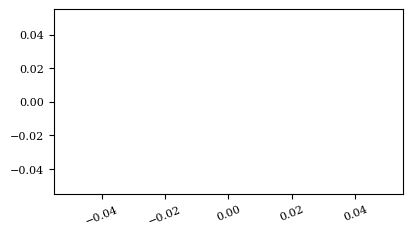

In [8]:


# df = pd.read_csv(CSV_FILE)
# df = df[df["name"].isin(benches_to_plot)]

# df = df.groupby("name").mean()


# # df.set_index(df.index.str.replace(f"_{NUM_QUBITS}_", "_"), inplace=True)
# # reorder columns
# # df = df[["qtpu", "scaleqc", "ckt", "cutqc"]]
WIDE_FIGSIZE = (4.5, 2.4)

fig, ax = plt.subplots(figsize=WIDE_FIGSIZE)
plot([ "linear", "clu", "rnd"], ax)
# ax.set_ylim(0, 1e10)
ax.set_yscale("log")


ax.legend()

# import seaborn as sns

# colors = sns.color_palette("tab10", n_colors=4)

# df.plot.bar(rot=15, width=0.8, edgecolor="black", linewidth=2, ax=ax, color=colors, legend=False)

# # for ytick in ax.get_yticklabels():
# # ytick.set_text(f"$10^{{{ytick.get_text()}}}$")

# ax.set_yticklabels([f"$10^{{{int(x.get_text())}}}$" for x in ax.get_yticklabels()])
# ax.set_title("Lower is better", fontweight="bold", color="midnightblue")
# ax.set_xlabel("")
# fig;

In [ ]:
fig.savefig("cost.pdf", bbox_inches="tight")